In [427]:
import numpy as np
import pandas as pd
import glob

#preprocessing data tools
from sklearn.preprocessing import MinMaxScaler
from numpy.fft import fft, fftfreq
from scipy import signal
from scipy.io import wavfile

#neural network tools
#camadas possíveis
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv1D,MaxPooling1D,UpSampling1D
from keras.layers.normalization import BatchNormalization

#leakyrelu permite um gradiente pequeno quando o neurônio não está ativo.
#ela tem uma pequena parte quando potencial de ação é negativo
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model,Sequential
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
#é sempre bom utilizar callbacks para evitar problemas durante a convergência do algoritmo
from keras import callbacks

#kfold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#ferramentas gráficas
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Importando os Dados

In [397]:
path = "/media/gabriel/OS/Users/gabriel.gomes/Google Drive/Radice - Pós-Graduação/Disciplinas/Trabalho Final - SEL5712 e SEL5742/Arquivos de Dados/Testes 05_07_19/freq/*.wav"
ys = []
fnames = []
y = []
cont = 0
resh = True #habilita ou desabilita divisão dos dados em dados menores.
for fname in glob.glob(path): #utiliza a biblioteca glob para varrer a pasta na qual os arquivos (loop)
    
    waveF = []
    fnames.append(fname) 
    #lê p .wav
    fs, data = wavfile.read(fname)
    #limitando o tamanho das amostras, porque devido ao fato do sensor variar o tamanho da amostra pelo clique do
    #operador, é necessário normalizar
    data = np.array(data[0:150000])
    #dividindo em 10 partes de 15000 amostras, que dá quase um segundo.
    if(resh == True):
        data = np.reshape(data,(10,15000))
        for d in data:
            y.append(d) #adiciona ao vetor de dadas linha a linha os dados
    else:        
        y.append(data)
    if(cont == 13):
        break
    cont += 1

#pega o nome dos arquivos, remove o path deles por espaço.
fnames = [f.replace('C:\\Users\\gabriel.gomes\\Google Drive\\Radice - Pós-Graduação\Disciplinas\Trabalho Final - \
SEL5712 e SEL5742\\Arquivos de Dados\Amostras Aleatórias\\', '') for f in fnames]

#converte y para dataframe
df = pd.DataFrame(np.array(y))

#criando o nome das colunas para o dataframe

#20 = 10 de um lado, 10 do outro
n_samples = 14
index = []
j = 0

if(resh == True):
    for i in range(n_samples*10):
        if(i%n_samples == 0 and i > 0):
            j += 1 
        #da o nome de Amostra (Am) x, parte y (com parte variando de 1 
        #até o número de partes no qual os dados foram divididos)
        index.append("Am." + str(int(i/n_samples)+1) + "p." + str(i-j*n_samples))
else:
    for i in range(n_samples):
        index.append("Am." + str(i))
        
df.index = index
#definindo os labels das amostras: 0 -> sem defeito; 1 -> com defeito
#Assim como cortou as amostras, tem que cortar os labels
n_def = 4;
n_ok = 3;
labels = []
labels[0:int(10*(n_def/(n_ok+n_def))*n_samples+1)] = [1 for i in range(int(10*(n_def/(n_ok+n_def))*n_samples+1))]
labels[int(10*(n_def/(n_ok+n_def))*n_samples+1):] = [0 for i in range(int(10*(n_def/(n_ok+n_def))*n_samples+1),10*n_samples)]
labels = pd.DataFrame(labels)
labels.index = index
#confere se os labels estão ok.
labels.head()

labels_orig = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

In [398]:
#conferindo se os labels foram colocados de maneira corrreta
pd.value_counts(labels.iloc[:][0])

1    80
0    60
Name: 0, dtype: int64

# Análise do espectro de frequência dos sinais e classificação por espectro de frequência
Análise da resposta em frequência dos sinais sem defeito e dos sinais com defeito. Foi utilizada a FFT média para analisar a semelhança ou diferença entre os espectros médios.

In [399]:
#faz a fft de uma linha só para não ter que ficar fazendo toda hora
#uma análise diferente do tamanho do vetor
f, Pxx_den = signal.periodogram(df.iloc[0][:], fs)

meanf_ok = Pxx_den - Pxx_den #cria vetor de nulos
meanf_nok = Pxx_den - Pxx_den #cria vetor de nulos
count_ok = 0
count_nok = 0
fourier = []
#faz a média dos espectros de frequência com defeito e sem defeito
for i in range(len(df)):
    f, Pxx_den = signal.periodogram(df.iloc[i][:], fs)
    if(labels.iloc[i][0] == 0):
        #meanf_ok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den)) #normalizando os coeficientes.
        meanf_ok += Pxx_den/max(Pxx_den)
        fourier.append((Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))) #resultado da transformada de Fourier
        count_ok += 1
    else:
        fourier.append((Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))) #resultado da transformada de Fourier
        meanf_nok += Pxx_den/max(Pxx_den)
        #?meanf_nok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))
        count_nok += 1

### Transformada de Fourier Janelada de um sinal com defeito e um sem

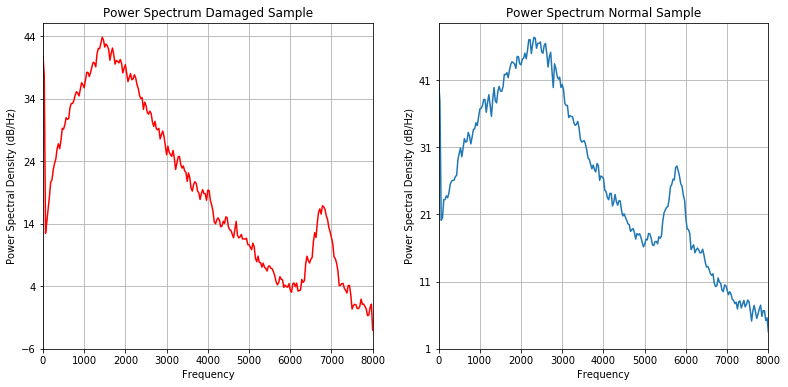

In [400]:
#amostras individuais
plt.figure(figsize=(13, 6))
plt.subplot(1,2,1)
plt.psd(df.iloc[0][:],512,fs, c = 'r')
plt.title("Power Spectrum Damaged Sample")
plt.xlim([0, 8000])
plt.subplot(1,2,2)
plt.psd(df.iloc[13][:],512,fs)
plt.title("Power Spectrum Normal Sample")
plt.xlim([0, 8000])
plt.show()

### Expectro médio de Fourier

In [401]:
        
#deixar o gráfico bonitinho e mais legível
meanf_ok = meanf_ok/len(labels) #média
meanf_nok = meanf_nok/len(labels)
meanf_ok = meanf_ok/max(meanf_ok) #normaliza pelo máximo
meanf_nok = meanf_nok/max(meanf_nok)


#cria um dataframe dos isoladores com defeito e sem defeito
fourier_df = pd.DataFrame(np.array([f, meanf_nok, meanf_ok]).T)
fourier_df.columns = ["Frequency [Hz]", "Broken", "Normal"]
fourier_df.head()

# Create traces
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("Broken","Normal", "Superposed"))

#média do fourier das amostras quebradas
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Broken'],
                    mode='lines',
                    name='Broken'), row=1, col=1)

#média das amostras ok
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Normal'],
                    mode='lines', name='Normal'), row=1, col=2)


#gráfico de superposição de ambos
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Broken'],
                    mode='lines',
                    name='Broken'), row=2, col=1)

fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Normal'],
                    mode='lines', name='Normal'), row=2, col=1)

fig.update_layout(title='Mean Fourier Transform', showlegend=False,
                   xaxis_title='Frequency [Hz]',
                   yaxis_title='Modulus')

fig.show()

In [402]:
#Cortando na região de interesse
fu_cutted = []
f_cut_sup = 3000
f_cut_inf = 500
l_inf = int(f_cut_inf*len(f)/8000)
l_sup = int(f_cut_sup*len(f)/8000)
for f in fourier:
    fu_cutted.append(f[l_inf:l_sup])
meanf_ok = fu_cutted[0] - fu_cutted[0] #cria vetor de nulos
meanf_nok = fu_cutted[0]- fu_cutted[0] #cria vetor de nulos

    
    
for i in range(len(fu_cutted)):
    if(labels.iloc[i][0] == 0):
        #meanf_ok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den)) #normalizando os coeficientes.
        meanf_ok += fu_cutted[i]/max(fu_cutted[i])
        count_ok += 1
    else:
        meanf_nok += fu_cutted[i]/max(fu_cutted[i])
        #?meanf_nok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))
        count_nok += 1

In [403]:
len(meanf_nok)

2344

In [404]:

#cortando o espectro de frequência
#deixar o gráfico bonitinho e mais legível
meanf_ok = meanf_ok/len(labels) #média
meanf_nok = meanf_nok/len(labels)
meanf_ok = meanf_ok/max(meanf_ok) #normaliza pelo máximo
meanf_nok = meanf_nok/max(meanf_nok)

f = [i for i in range(len(meanf_ok))] #cria o vetor de tempo
#cria um dataframe dos isoladores com defeito e sem defeito
fourier_df = pd.DataFrame(np.array([f, meanf_nok, meanf_ok]).T)
fourier_df.columns = ["Frequency [Hz]", "Broken", "Normal"]
fourier_df.head()

# Create traces
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("Broken","Normal", "Superposed"))

#média do fourier das amostras quebradas
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Broken'],
                    mode='lines',
                    name='Broken'), row=1, col=1)

#média das amostras ok
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Normal'],
                    mode='lines', name='Normal'), row=1, col=2)


#gráfico de superposição de ambos
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Broken'],
                    mode='lines',
                    name='Broken'), row=2, col=1)

fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Normal'],
                    mode='lines', name='Normal'), row=2, col=1)

fig.update_layout(title='Mean Fourier Transform', showlegend=False,
                   xaxis_title='Samples',
                   yaxis_title='Modulus')

fig.show()

Como é possível ver, existe uma diferença média no espectro entre 1000 e 2000 Hz. Portanto, os espectros médios da janela são diferentes! Logo, podemos utilizar a transformada de Fourier Janelada para fazer a análise.

Como a transformada de Fourier possui muitas amostras, no caso, 7501, devemos fazer uma reamostragem para tornar isso compatível com a rede. Iremos fazer isso utilizando uma subamostragem por Fourier! Essa subamostragem por Fourier se comporta como uma compactação. A maneira de compactar o 

In [409]:
# nas redes neurais.
data = signal.resample(fu_cutted,1500,axis = 1) #subamostrando segundo as colunas.

#porque nós fizemos o fourier recomp.min e vimos que nesse trecho existem valores negativos
# que matematicamente não fazem sentido, estamos adotando o abs, para que daqui para frente
#nada seja negativo
# comparar o signal reconstruído com o subamostrado
fourier_recomp = signal.resample(data,len(fu_cutted[0]), axis = 1)

In [410]:
#Coeficiente de correlação foi para 0.71 porem, o importante é saber se o espectro médio atinda tem diferença!
np.corrcoef(fourier_recomp[4], fu_cutted[4])


array([[1.        , 0.85867471],
       [0.85867471, 1.        ]])

In [411]:
#faz a média dos espectros de frequência com defeito e sem defeito
meanf_ok = data[1] - data[1] #cria vetor de nulos
meanf_nok = data[1] - data[1]#cria vetor de nulos
count_ok = 0
count_nok = 0
fourier_norm = [] #fourier normalizado
for i in range(len(labels)):
    if(labels.iloc[i][0] == 0):
        data[i] = (data[i]/max(data[i])) #normaliza o dado pelo máximo
        meanf_ok += data[i]
        count_ok += 1 #contador para verificar se o número de amostras sem defeito está correto
    else:
        data[i] = (data[i]/max(data[i]))
        meanf_nok += data[i]
        count_nok += 1 #contador para verificar se o número de amostras com defeito está correto

In [412]:
        
#deixar o gráfico bonitinho e mais legível
meanf_ok = meanf_ok/len(labels) #média
meanf_nok = meanf_nok/len(labels)
meanf_ok = meanf_ok/max(meanf_ok) #normaliza pelo máximo
meanf_nok = meanf_nok/max(meanf_nok)

f = [i for i in range(len(meanf_ok))] #cria o vetor de tempo
#cria um dataframe dos isoladores com defeito e sem defeito
fourier_df = pd.DataFrame(np.array([f, meanf_nok, meanf_ok]).T)
fourier_df.columns = ["Frequency [Hz]", "Broken", "Normal"]
fourier_df.head()

# Create traces
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("Broken","Normal", "Superposed"))

#média do fourier das amostras quebradas
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Broken'],
                    mode='lines',
                    name='Broken'), row=1, col=1)

#média das amostras ok
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Normal'],
                    mode='lines', name='Normal'), row=1, col=2)


#gráfico de superposição de ambos
fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Broken'],
                    mode='lines',
                    name='Broken'), row=2, col=1)

fig.add_trace(go.Scatter(x=fourier_df['Frequency [Hz]'],y=fourier_df['Normal'],
                    mode='lines', name='Normal'), row=2, col=1)

fig.update_layout(title='Mean Fourier Transform', showlegend=False,
                   xaxis_title='Samples',
                   yaxis_title='Modulus')

fig.show()

Como é possível perceber, a diferença no espectro de frequência foi preservada, logo essa abordagem pode ser utilizada.
Uma outra possibilidade é utilizar um PCA aqui. O problema é que como temos apenas 200 amostras, vai ser difícil preservar a variância porque o máximo de coeficientes possível serão 200, então nem compensa tentar. 

Outra coisa interessante a ser feita é cortar a primeira parte do espectro. Porque ela tem uns picos estranhos, que podem fazer com que o modelo se vicie. Outra coisa é cortar a parte final também, porque não tem nada de difença. Daria até mesmo para deixar os dados entre 1000 e 3000 Hz, que seria outro teste.

# Rede Neural

In [413]:
#colocando as informações no formato da rede.

#para dados sem cortar
data = np.expand_dims(np.array(data),axis= 2) 



In [428]:
# # #callbacks

# # cb1 = EarlyStopping(monitor='val_acc', mode='max', baseline=0.93)
# # cb2 = EarlyStopping(monitor='acc', mode='max', baseline=0.93)
# # callbacks = [cb2 , cb1]

class EarlyStoppingByLossVal(callbacks.Callback):
     def __init__(self, monitor='custom', value=0.80, verbose=0):
         super(callbacks.Callback, self).__init__()
         self.monitor = monitor
         self.value = value
         self.verbose = verbose

     def on_epoch_end(self, epoch, logs={}):
         self.monitor = 'val_acc'
         val_ac = logs.get(self.monitor)
         self.monitor = 'acc'
         ac = logs.get(self.monitor)
         if (val_ac or ac)is None:
             warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

         if (val_ac >= self.value) and (ac >= self.value):
             if self.verbose > 0:
                 print("Epoch %05d: early stopping THR" % epoch)
             self.model.stop_training = True

callbacks = [
    EarlyStoppingByLossVal(monitor='custom', value=0.80, verbose=1),
]

Usando k-fold cross validation

In [415]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=10)

In [416]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)
ea

In [417]:
len(data[0])

1500

In [438]:
cvscores = []
labels = np.array(labels)
arquitetura = []
for train, test in kfold.split(data, labels):
  # create model
    convolutional_NN = Sequential()
    convolutional_NN.add(Dense(100, activation='relu',input_shape=(data.shape[1],1)))
    convolutional_NN.add(Conv1D(100,kernel_size = 15, activation = 'relu')) #kernel_size = 10
    convolutional_NN.add(MaxPooling1D((2)))
    convolutional_NN.add(Conv1D(80,kernel_size = 5, activation = 'relu')) #kernel_size = 5;
    convolutional_NN.add(Dense(80, activation='relu'))
    convolutional_NN.add(Dropout(rate = 0.615))
    convolutional_NN.add(Flatten())
    convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    
    # Compile model
    convolutional_NN.compile(loss='mean_squared_error', optimizer = Adam(),metrics=['accuracy'],  
                             )
    
    # Fit the model
    convolutional_NN.fit(data[train], labels[train], epochs=30, batch_size=64, verbose=1
                         , validation_data=(data[test], np.array(labels)[test]))
    # evaluate the model
    scores = convolutional_NN.evaluate(data[test], np.array(labels)[test], verbose=0)
    arquitetura.append(convolutional_NN)
    print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Train on 116 samples, validate on 24 samples
Epoch 1/30
116/116 [==============================] - 22s 193ms/step - loss: 0.2491 - acc: 0.4828 - val_loss: 0.2387 - val_acc: 0.5833
Epoch 2/30
116/116 [==============================] - 2s 16ms/step - loss: 0.2508 - acc: 0.5690 - val_loss: 0.2348 - val_acc: 0.5833
Epoch 3/30
116/116 [==============================] - 2s 14ms/step - loss: 0.2435 - acc: 0.5690 - val_loss: 0.2429 - val_acc: 0.7500
Epoch 4/30
116/116 [==============================] - 2s 15ms/step - loss: 0.2383 - acc: 0.7328 - val_loss: 0.2370 - val_acc: 0.5833
Epoch 5/30
116/116 [==============================] - 2s 14ms/step - loss: 0.2329 - acc: 0.5862 - val_loss: 0.2248 - val_acc: 0.5833
Epoch 6/30
116/116 [==============================] - 2s 13ms/step - loss: 0.2281 - acc: 0.5690 - val_loss: 0.2143 - val_acc: 0.5833
Epoch 7/30
116/116 [==============================] - 2s 14ms/step - loss: 0.2266 - acc: 0.5690 - val_loss: 0.2056 - val_acc: 0.8333
Epoch 8/30
116/116 [==

117/117 [==============================] - 20s 169ms/step - loss: 0.2502 - acc: 0.4786 - val_loss: 0.2431 - val_acc: 0.5652
Epoch 2/30
117/117 [==============================] - 2s 14ms/step - loss: 0.2454 - acc: 0.5726 - val_loss: 0.2373 - val_acc: 0.5652
Epoch 3/30
117/117 [==============================] - 2s 14ms/step - loss: 0.2376 - acc: 0.5726 - val_loss: 0.2337 - val_acc: 0.5652
Epoch 4/30
117/117 [==============================] - 2s 14ms/step - loss: 0.2303 - acc: 0.5726 - val_loss: 0.2255 - val_acc: 0.5652
Epoch 5/30
117/117 [==============================] - 2s 16ms/step - loss: 0.2233 - acc: 0.5726 - val_loss: 0.2165 - val_acc: 0.7826
Epoch 6/30
117/117 [==============================] - 2s 14ms/step - loss: 0.2184 - acc: 0.6239 - val_loss: 0.2125 - val_acc: 0.7391
Epoch 7/30
117/117 [==============================] - 2s 18ms/step - loss: 0.2087 - acc: 0.6838 - val_loss: 0.1962 - val_acc: 0.7826
Epoch 8/30
117/117 [==============================] - 2s 16ms/step - loss: 0.1

117/117 [==============================] - 21s 179ms/step - loss: 0.2484 - acc: 0.4701 - val_loss: 0.2408 - val_acc: 0.5652
Epoch 2/30
117/117 [==============================] - 2s 13ms/step - loss: 0.2387 - acc: 0.5726 - val_loss: 0.2353 - val_acc: 0.5652
Epoch 3/30
117/117 [==============================] - 2s 13ms/step - loss: 0.2279 - acc: 0.5726 - val_loss: 0.2301 - val_acc: 0.5652
Epoch 4/30
117/117 [==============================] - 2s 14ms/step - loss: 0.2123 - acc: 0.6838 - val_loss: 0.2297 - val_acc: 0.6522
Epoch 5/30
117/117 [==============================] - 2s 14ms/step - loss: 0.2248 - acc: 0.5726 - val_loss: 0.2245 - val_acc: 0.5652
Epoch 6/30
117/117 [==============================] - 2s 18ms/step - loss: 0.2205 - acc: 0.7009 - val_loss: 0.2581 - val_acc: 0.5652
Epoch 7/30
117/117 [==============================] - 2s 15ms/step - loss: 0.1910 - acc: 0.7179 - val_loss: 0.2359 - val_acc: 0.6522
Epoch 8/30
117/117 [==============================] - 2s 15ms/step - loss: 0.1

In [ ]:
erro_med = 0
for j in range(len(arquitetura)):
    modelo = arquitetura[j]
    erro = 0
    labelsPred = []
    for i in range(14):
        vect = modelo.predict(data[(10*i):10*(i+1)])
        meanV = sum(vect)/10
        if(meanV >= 0.5):
            labelsPred.append(1)
        else:
            labelsPred.append(0)    
    
    erro = 0
    soma = []
    soma.append([abs(labelsPred[i]-labels_orig[i]) for i in range(len(labelsPred))])
    print(labelsPred)
  

    erro = sum(soma[0])/14
    erro_med += erro
    print("O erro do modelo ",j," é ", erro*100, "%")

print("O erro médio é ", erro_med/6*100, "%")
                    

In [328]:
erro = 0
soma = []
soma.append([abs(labelsPred[i]-labels_orig[i]) for i in range(len(labelsPred))])
print(soma)

erro = sum(soma[0])/14
print("O erro é", erro*100, "%")

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]
O erro é 7.142857142857142 %


In [435]:
vect = modelo.predict(data[(10*0):10*(0+1)])

In [436]:
vect

array([[0.99466383],
       [0.9987829 ],
       [0.9962245 ],
       [0.99897003],
       [0.9871606 ],
       [0.9994792 ],
       [0.96729577],
       [0.8928781 ],
       [0.99990475],
       [0.98234046]], dtype=float32)